<a href="https://colab.research.google.com/github/nikhilcoding0013/Basketball-Game-Predictor/blob/main/1B_WHARTON_DATASCIENCE_COMPETITION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import csv
df = pd.read_csv('games_2022 - games_2022 (1).csv')
df['OT_length_min_tot'] = df['OT_length_min_tot'].map(lambda x: 0 if pd.isna(x) else x)
df['notD1_incomplete']=df['notD1_incomplete'].map({False:0, True:1})
print(df.head())
print(df['notD1_incomplete'][2232])

          game_id   game_date                       team  FGA_2  FGM_2  FGA_3  \
0  game_2022_2011  2021-12-30      georgia_lady_bulldogs     50     22     11   
1  game_2022_2011  2021-12-30                 lsu_tigers     50     24     11   
2  game_2022_2012  2021-12-30            missouri_tigers     43     18     15   
3  game_2022_2012  2021-12-30   south_carolina_gamecocks     55     23     21   
4  game_2022_2013  2021-12-30  tennessee_lady_volunteers     41     20     15   

   FGM_3  FTA  FTM  AST  ...  largest_lead  notD1_incomplete  \
0      5    6    3   14  ...           1.0                 0   
1      4   15    8   15  ...          14.0                 0   
2      7   16   13   10  ...           8.0                 0   
3      6    9    5   15  ...           6.0                 0   
4      4   15   10   16  ...          19.0                 0   

   OT_length_min_tot  rest_days  attendance  tz_dif_H_E  prev_game_dist  \
0                0.0        9.0      3241.0         0

In [ ]:
df['home_away']=df['home_away'].map({'home':0, 'away':1})

In [ ]:
df.head()
print(df.shape)

(10438, 30)


In [ ]:
import math
teamnames={"georgia_lady_bulldogs"}
for i in range(10438):
  teamnames.add(df['team'][i])
print(len(teamnames))
ELO ={}
for i in teamnames:
  ELO[i]=1500
K=0
for k in range(10):
  for j in range(5219):
    if (df["team_score"][2*j]>df["opponent_team_score"][2*j]):
      ELO[df["team"][2*j]]+=6*(df["team_score"][2*j]/df["opponent_team_score"][2*j])+3*math.log(ELO[df['team'][2*j+1]]/ELO[df['team'][2*j]])+K
    elif (df["team_score"][2*j]<df["opponent_team_score"][2*j]):
      ELO[df["team"][2*j]]-=6*(df["team_score"][2*j]/df["opponent_team_score"][2*j])+ 3*math.log(ELO[df['team'][2*j]]/ELO[df['team'][2*j+1]])+K
  for j in range(5220):
    if (j>1):
      if (df["team_score"][2*j-1]>df["opponent_team_score"][2*j-1]):
        ELO[df["team"][2*j-1]]+=6*(df["opponent_team_score"][2*j-1]/df["team_score"][2*j-1]) +3*math.log(ELO[df['team'][2*j-2]]/ELO[df['team'][2*j-1]])+K
      elif (df["team_score"][2*j-1]<df["opponent_team_score"][2*j-1]):
        ELO[df["team"][2*j-1]]-=6*(df["opponent_team_score"][2*j-1]/df["team_score"][2*j-1])+3*math.log(ELO[df['team'][2*j-1]]/ELO[df['team'][2*j-2]])+K
ELOLIST= []
ELODICT={}
for i in teamnames:
  ELOLIST.append(ELO[i])
  ELODICT[ELO[i]]=i
ELOLIST.sort()

564


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
df = pd.read_csv('games_2022 - games_2022 (1).csv')

features = ['AST', 'BLK', 'STL', 'TOV', 'TOV_team', 'DREB', 'OREB',
            'F_tech', 'F_personal', 'team_score', 'opponent_team_score',
            '2P%', '3P%', 'FT%', 'home_away', 'rest_days_OPP', 'travel_dist_OPP', 'rest_days', 'travel_dist']
df['win'] = (df['team_score'] > df['opponent_team_score']).astype(int)
df['2P%'] = df['FGA_2']/df['FGM_2']
df['3P%'] = df['FGA_3']/df['FGM_3']
df['rest_days_OPP'] = df['rest_days'].shift(-1)  # Next row's home rest days
df['travel_dist_OPP'] = df['travel_dist'].shift(-1)  # Next row's home travel distance
df['home_away']=df['home_away'].map({'home':0, 'away':1})
df['FT%']=df['FTA']/df['FTM']
scaler = StandardScaler()
df.fillna(0, inplace=True)
df[features] = df[features].replace([np.inf, -np.inf], np.nan)

df[features] = scaler.fit_transform(df[features])
X_train, X_test, y_train, y_test = train_test_split(df[features], df['win'], test_size=0.2, random_state=42)
X_train = X_train.fillna(0)
model = keras.Sequential([
    keras.layers.Dense(32, activation='relu', input_shape=(len(features),)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')  # Output layer for probability
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")
model.save("basketball_win_predictor.h5")
def predict_game(team_stats):
    """ Predicts win probability given team stats """
    team_stats_scaled = scaler.transform([team_stats])
    prob = model.predict(team_stats_scaled)[0][0]
    return prob
playoff_game = df[features].iloc[0].values
win_prob = predict_game(playoff_game)
print(f"Predicted Win Probability: {win_prob:.4f}")


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8116 - loss: 0.4432 - val_accuracy: 0.9483 - val_loss: nan
Epoch 2/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9613 - loss: 0.1158 - val_accuracy: 0.9722 - val_loss: nan
Epoch 3/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9805 - loss: 0.0573 - val_accuracy: 0.9794 - val_loss: nan
Epoch 4/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9909 - loss: 0.0362 - val_accuracy: 0.9842 - val_loss: nan
Epoch 5/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9943 - loss: 0.0255 - val_accuracy: 0.9856 - val_loss: nan
Epoch 6/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9966 - loss: 0.0170 - val_accuracy: 0.9880 - val_loss: nan
Epoch 7/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9990 - loss: 0.0123 - val_accuracy: 0.9890 - val_loss: nan
Epoch 8/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9990 - loss: 0.0103 - val_accuracy: 0.9895 - val_loss: nan
Epoch 9/50


Test Accuracy: 0.9852
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Predicted Win Probability: 0.8674


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
games_to_predict = pd.read_csv('games_2022 - games_2022 (1).csv')
# Select relevant columns for prediction
features = ['home_away_NS', 'rest_days_Away', 'travel_dist_Away']
X_predict = games_to_predict[features]

# Standardize using the same scaler from training
X_predict = scaler.transform(X_predict)  # Use previously fitted scaler

# Predict win probabilities
win_probabilities = model.predict(X_predict)

# Assign predictions to dataframe
games_to_predict['win_probability_home'] = win_probabilities
games_to_predict['predicted_winner'] = np.where(win_probabilities > 0.5, games_to_predict['team_home'], games_to_predict['team_away'])

# Print predictions
print(games_to_predict[['team_home', 'team_away', 'win_probability_home', 'predicted_winner']])


KeyError: "['rest_days_Away', 'travel_dist_Away'] not in index"

In [ ]:
# Importing essential libraries

# For data manipulation and loading
import pandas as pd
import numpy as np

# For splitting the data into training and testing sets
from sklearn.model_selection import train_test_split

# For evaluation metrics (MAE, MSE, RMSE, R2)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# For scaling features (optional but recommended for some models)
from sklearn.preprocessing import StandardScaler

# XGBoost library for model building
import xgboost as xgb

# After the upload, you can load your CSV as follows:
df = pd.read_csv('games_2022 - games_2022 (1).csv')

# Display the first few rows and add win column
df['win'] = (df['opponent_team_score'] < df['team_score']).astype(int)
print(df.head())




          game_id   game_date                       team  FGA_2  FGM_2  FGA_3  \
0  game_2022_2011  2021-12-30      georgia_lady_bulldogs     50     22     11   
1  game_2022_2011  2021-12-30                 lsu_tigers     50     24     11   
2  game_2022_2012  2021-12-30            missouri_tigers     43     18     15   
3  game_2022_2012  2021-12-30   south_carolina_gamecocks     55     23     21   
4  game_2022_2013  2021-12-30  tennessee_lady_volunteers     41     20     15   

   FGM_3  FTA  FTM  AST  ...  notD1_incomplete  OT_length_min_tot  rest_days  \
0      5    6    3   14  ...             False                NaN        9.0   
1      4   15    8   15  ...             False                NaN        3.0   
2      7   16   13   10  ...             False                5.0        8.0   
3      6    9    5   15  ...             False                5.0        9.0   
4      4   15   10   16  ...             False                NaN        3.0   

   attendance  tz_dif_H_E  prev_

In [ ]:
dfn = df.drop(columns=['F_tech', 'F_personal', 'game_id', 'attendance', 'tz_dif_H_E', 'prev_game_dist', 'TOV_team', 'home_away', 'game_date', 'FGA_2', 'FGM_2', 'FGA_3', 'FGM_3', 'FTA', 'FTM',  'AST',  'BLK',  'STL',  'TOV',  'DREB',  'OREB',  'team_score',  'opponent_team_score', 'largest_lead', 'OT_length_min_tot'])
dfn.loc[dfn['home_away_NS'] == -1, 'travel_dist'] = 0
dfn['notD1_incomplete'] = dfn['notD1_incomplete'].astype(int)

expected_probs = []
for i in range(0, len(df), 2):
    team_A = dfn.iloc[i]  # First row (Team 1)
    team_B = dfn.iloc[i+1]  # Second row (Team 2)
    P_A = expected_win_prob(team_A['team'], team_B['team'])
    P_B = 1 - P_A
    expected_probs.append(P_A)
    expected_probs.append(P_B)
dfn['expected_win_prob'] = expected_probs

print(dfn.head())
dfn.columns

                        team  notD1_incomplete  rest_days  home_away_NS  \
0      georgia_lady_bulldogs                 0        9.0             1   
1                 lsu_tigers                 0        3.0            -1   
2            missouri_tigers                 0        8.0             1   
3   south_carolina_gamecocks                 0        9.0            -1   
4  tennessee_lady_volunteers                 0        3.0             1   

   travel_dist  expected_win_prob  
0          0.0                0.5  
1          0.0                0.5  
2          0.0                0.5  
3          0.0                0.5  
4          0.0                0.5  


Index(['team', 'notD1_incomplete', 'rest_days', 'home_away_NS', 'travel_dist',
       'expected_win_prob'],
      dtype='object')

In [ ]:
df0 = dfn.drop(columns=['team'])
df0.columns

Index(['notD1_incomplete', 'rest_days', 'home_away_NS', 'travel_dist', 'win'], dtype='object')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

def report_nans(df):
    nan_report = df.isna().sum()
    nan_instances = nan_report[nan_report > 0]

    if nan_instances.empty:
        print("No NaN values found in the DataFrame.")
    else:
        print("NaN values found in the following columns:")
        for col, count in nan_instances.items():
            print(f"Column: {col}, NaN Count: {count}")

df0.fillna(0, inplace=True)
df0.columns

report_nans(df0)

No NaN values found in the DataFrame.


In [ ]:
X = df0[['notD1_incomplete', 'rest_days', 'home_away_NS', 'travel_dist', 'expected_win_prob']]
y = df0['win']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

poly = PolynomialFeatures(degree=2)  # Try different degrees (e.g., 3, 4) for better fit
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train_poly, y_train)

KeyError: "['expected_win_prob'] not in index"

In [ ]:
print(lr.score(X_test_poly, y_test))
print(lr.score(X_train_poly, y_train))
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
y_pred = lr.predict(X_test_poly)

print("MSE: " + str(mean_squared_error(y_test, y_pred)))
print("R2: " + str(r2_score(y_test, y_pred)))

0.33206103362710404
0.3257169742143011
MSE: 0.16695471321600525
R2: 0.33206103362710404


In [ ]:
print("percent accuracy: " + str(100*((lr.score(X_train_poly, y_train))/(lr.score(X_test_poly, y_test)))) +"%")

percent accuracy: 98.08948995204082%


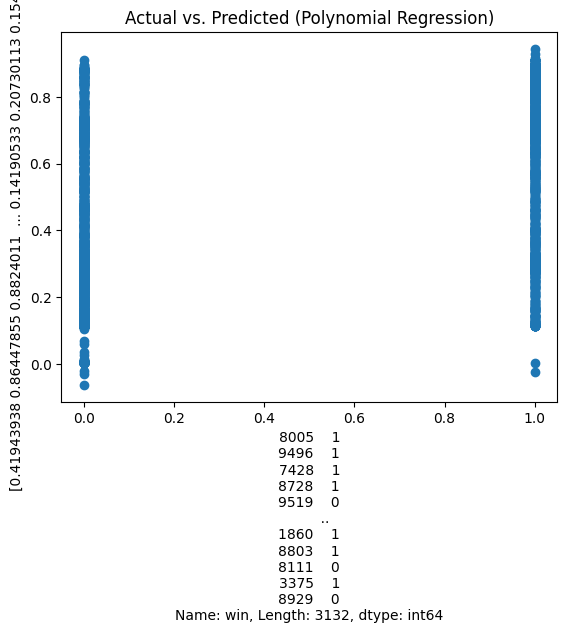

In [ ]:
plt.scatter(y_test, y_pred)
plt.xlabel(y_test)
plt.ylabel(y_pred)
plt.title("Actual vs. Predicted (Polynomial Regression)")
plt.show()

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

y_prob = sigmoid(y_pred)

In [ ]:
# Function to get final Elo rating of a given team
def get_team_elo(team_name):
    if team_name in final_elo_ratings:
        return f"Final Elo rating for {team_name}: {final_elo_ratings[team_name]}"
    else:
        return f"Team {team_name} not found in the final Elo ratings."

print(get_team_elo(input("Enter team name: ")))

Enter team name: columbia_lions
Final Elo rating for columbia_lions: 4253.833854929918


In [ ]:
R_A = 3943.7
R_B = 4253.8
AP = 1 / (1 + 10 ** ((R_B - R_A) / 400))
BP = 1 - AP
print("AP = " + str(AP))
print("BP = " + str(BP))

AP = 0.14367710131477707
BP = 0.8563228986852229


In [ ]:
import numpy as np
'notD1_incomplete', 'rest_days', 'home_away_NS', 'travel_dist', 'expected_win_prob'

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

new_data_poly = poly.transform(np.array([[0, 7, 0, 350, 0.14367710131477707]]))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


In [ ]:
predicted_win_percentage = lr.predict(new_data_poly)
win_probability = sigmoid(predicted_win_percentage)

print(f"Predicted Win Probability: {win_probability[0]:.4f}")

Predicted Win Probability: 0.5781


In [ ]:
print(lr.n_features_in_)
print(X_train_poly.shape)
print(new_data_poly.shape)

21
(7306, 21)
(1, 21)


In [ ]:
lr.coef_

array([ 0.00000000e+00, -1.39185463e-01, -7.13398321e-03,  9.91257839e-02,
       -3.86452513e-05,  6.12483662e-01, -1.39185448e-01,  1.83089655e-12,
       -1.28646876e-01, -7.73950348e-13,  3.20845362e+01,  2.30020427e-04,
       -4.94274958e-03, -2.80637243e-06,  4.13572967e-03, -6.64062508e-02,
        1.31567072e-03, -4.79213075e-03,  1.20205166e-08, -4.80909145e-05,
       -1.25926430e-02])

In [ ]:
lr.intercept_

0.28325420362278153

In [ ]:
#predicting the necessary weights
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Merge dataset on game_id to pair teams
df1= pd.read_csv('Copy of games_2022 - games_2022.csv')
df_games = df1.merge(df, on="game_id", suffixes=("_A", "_B"))

# Keep only valid matchups (team_A ≠ team_B)
df_games = df_games[df_games["team_A"] != df_games["team_B"]]

# Select necessary columns
columns_needed = [
    "team_A", "team_B", "team_score_A", "team_score_B",
    "FGA_3_A", "FGM_3_A", "FGA_2_A", "FGM_2_A", "FTA_A", "FTM_A",
    "AST_A", "BLK_A", "STL_A", "TOV_A", "DREB_A", "OREB_A",
    "FGA_3_B", "FGM_3_B", "FGA_2_B", "FGM_2_B", "FTA_B", "FTM_B",
    "AST_B", "BLK_B", "STL_B", "TOV_B", "DREB_B", "OREB_B"
]

df_games = df_games[columns_needed].drop_duplicates()

# Save formatted dataset
df_games.to_csv("formatted_games.csv", index=False)
print("Formatted dataset saved successfully.")

# Load your historical game data
# The CSV should include columns: AST_A, AST_B, BLK_A, BLK_B, STL_A, STL_B, TOV_A, TOV_B, DREB_A, DREB_B, OREB_A, OREB_B, and 'result'
# where 'result' is 1 if Team A won, 0 otherwise.
df3 = pd.read_csv('formatted_games.csv')

# Calculate differences for each advanced stat
stat_list = ['AST', 'BLK', 'STL', 'TOV', 'DREB', 'OREB']
for stat in stat_list:
    df3[f'{stat}_diff'] = df3[f'{stat}_A'] - df3[f'{stat}_B']
# Determine the result column (1 if Team A won, 0 otherwise)
df3['result'] = (df3['team_score_A'] > df3['team_score_B']).astype(int)
# Select features and target
X = df3[[f'{stat}_diff' for stat in stat_list]]
y = df3['result']  # Binary outcome: 1 if Team A wins, 0 if not

# Optional: Standardize features (helps with convergence and interpretability)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Retrieve the learned coefficients
learned_coeffs = model.coef_[0]

# Map coefficients to the stat_weighting dictionary
predicted_stat_weighting = dict(zip(stat_list, learned_coeffs))
print("Predicted advanced stat weights:", predicted_stat_weighting)


Formatted dataset saved successfully.
Predicted advanced stat weights: {'AST': 1.2096897813756242, 'BLK': 0.11042661188571065, 'STL': 0.1753022616798368, 'TOV': -4.651538446135684, 'DREB': 5.467526587946814, 'OREB': -0.16406959836102708}


In [ ]:
#ELO model

import pandas as pd
import numpy as np

# Initialize Elo ratings dictionary
elo_ratings = {}  # This will store each team's current Elo rating

def get_elo(team):
    """Retrieve the team's current Elo rating. If they don't have one, assign default 1500."""
    if team not in elo_ratings:
        elo_ratings[team] = 1500  # Default starting Elo
    return elo_ratings[team]

#logistic function which calculates exprected win prob for team_A
def expected_win_prob(team_A, team_B):
    """Calculate the probability of Team A winning against Team B based on Elo ratings."""
    R_A = get_elo(team_A)
    R_B = get_elo(team_B)
    return 1 / (1 + 10 ** ((R_B - R_A) / 400))

#all this stuff below is to adjust the elo rating. look at elo update functions: it's based off what the expected win percentage was

def update_elo_with_advanced_stats(team_A, team_B, score_A, score_B,
                                   FGM_3_A, FGA_3_A, FGM_2_A, FGA_2_A, FTM_A, FTA_A, AST_A, BLK_A, STL_A, TOV_A, DREB_A, OREB_A,
                                   FGM_3_B, FGA_3_B, FGM_2_B, FGA_2_B, FTM_B, FTA_B, AST_B, BLK_B, STL_B, TOV_B, DREB_B, OREB_B):
    """Update Elo ratings with shooting efficiency and advanced stats like AST, BLK, STL, TOV, REB."""

    K = 40 #adjust based on rate of change for elo

    P_A = expected_win_prob(team_A, team_B)  # Expected probability of Team A winning
    P_B = 1 - P_A  # Expected probability of Team B winning

    # Determine actual result
    S_A, S_B = (1, 0) if score_A > score_B else (0, 1)  # 1 if win, 0 if loss

    # Calculate shooting efficiencies
    eff_3_A = FGM_3_A / FGA_3_A if FGA_3_A > 0 else 0  # 3PT efficiency
    eff_2_A = FGM_2_A / FGA_2_A if FGA_2_A > 0 else 0  # 2PT efficiency
    eff_ft_A = FTM_A / FTA_A if FTA_A > 0 else 0       # Free throw efficiency

    eff_3_B = FGM_3_B / FGA_3_B if FGA_3_B > 0 else 0
    eff_2_B = FGM_2_B / FGA_2_B if FGA_2_B > 0 else 0
    eff_ft_B = FTM_B / FTA_B if FTA_B > 0 else 0

    # Performance-based adjustments
    performance_factor = 10

    shooting_adjustment_A = performance_factor * (
        (eff_3_A - 0.35) + (eff_2_A - 0.50) + (eff_ft_A - 0.75)
    )
    shooting_adjustment_B = performance_factor * (
        (eff_3_B - 0.35) + (eff_2_B - 0.50) + (eff_ft_B - 0.75)
    )

    # Advanced stat impact
    stat_weighting = predicted_stat_weighting

    advanced_stat_adjustment_A = (
        AST_A * stat_weighting["AST"] +
        BLK_A * stat_weighting["BLK"] +
        STL_A * stat_weighting["STL"] +
        TOV_A * stat_weighting["TOV"] +
        DREB_A * stat_weighting["DREB"] +
        OREB_A * stat_weighting["OREB"]
    )

    advanced_stat_adjustment_B = (
        AST_B * stat_weighting["AST"] +
        BLK_B * stat_weighting["BLK"] +
        STL_B * stat_weighting["STL"] +
        TOV_B * stat_weighting["TOV"] +
        DREB_B * stat_weighting["DREB"] +
        OREB_B * stat_weighting["OREB"]
    )

    # Final Elo update
    elo_ratings[team_A] = get_elo(team_A) + K * (S_A - P_A) + shooting_adjustment_A + advanced_stat_adjustment_A
    elo_ratings[team_B] = get_elo(team_B) + K * (S_B - P_B) + shooting_adjustment_B + advanced_stat_adjustment_B
    return elo_ratings[team_A], elo_ratings[team_B]

In [ ]:

# Load the dataset
file_path = "/mnt/data/games_2022 - games_2022 (1).csv"
df = pd.read_csv(file_path)

# Display basic info and first few rows
df.info(), df.head()


In [ ]:
df2 = df.drop(columns=['game_date', 'F_tech', 'F_personal', 'largest_lead', 'OT_length_min_tot', 'attendance', 'tz_dif_H_E', 'prev_game_dist', 'rest_days', 'home_away', 'home_away_NS',
       'travel_dist', 'TOV_team'])

df2.columns
print(df2.head())

          game_id                       team  FGA_2  FGM_2  FGA_3  FGM_3  FTA  \
0  game_2022_2011      georgia_lady_bulldogs     50     22     11      5    6   
1  game_2022_2011                 lsu_tigers     50     24     11      4   15   
2  game_2022_2012            missouri_tigers     43     18     15      7   16   
3  game_2022_2012   south_carolina_gamecocks     55     23     21      6    9   
4  game_2022_2013  tennessee_lady_volunteers     41     20     15      4   15   

   FTM  AST  BLK  STL  TOV  DREB  OREB  team_score  opponent_team_score  \
0    3   14    7    7   18    25    11          62                   68   
1    8   15    2   15   14    25    11          68                   62   
2   13   10    1    4    8    31     6          70                   69   
3    5   15    8    3    8    27    20          69                   70   
4   10   16    8    5   15    34    12          62                   44   

   notD1_incomplete  win  
0             False    0  
1       

In [ ]:
final_elo_ratings = {}

# Loop through every two rows (each game has two rows)
for i in range(0, len(df), 2):
    team_A = df2.iloc[i]  # First row (Team 1)
    team_B = df2.iloc[i+1]  # Second row (Team 2)

    # Call the Elo update function
    new_elo_A, new_elo_B = update_elo_with_advanced_stats(
        team_A['team'], team_B['team'], team_A['team_score'], team_B['team_score'],
        team_A['FGM_3'], team_A['FGA_3'], team_A['FGM_2'], team_A['FGA_2'], team_A['FTM'], team_A['FTA'],
        team_A['AST'], team_A['BLK'], team_A['STL'], team_A['TOV'], team_A['DREB'], team_A['OREB'],
        team_B['FGM_3'], team_B['FGA_3'], team_B['FGM_2'], team_B['FGA_2'], team_B['FTM'], team_B['FTA'],
        team_B['AST'], team_B['BLK'], team_B['STL'], team_B['TOV'], team_B['DREB'], team_B['OREB']
        )
    final_elo_ratings[team_A['team']] = new_elo_A
    final_elo_ratings[team_B['team']] = new_elo_B

# Convert to DataFrame for better visualization
final_elo_df = pd.DataFrame(list(final_elo_ratings.items()), columns=['Team', 'Final_Elo'])
final_elo_df = final_elo_df.sort_values(by='Team', ascending=False)

# Display final Elo ratings
print(final_elo_df)

                                    Team    Final_Elo
339            youngstown_state_penguins  4235.378107
522  young_harris_college_mountain_lions  1575.086879
262                        yale_bulldogs  3663.885995
340                    xavier_musketeers  3747.915453
371                  xavier_la_gold_rush  1499.978866
..                                   ...          ...
64                            akron_zips  3928.109213
34                     air_force_falcons  3762.104896
448         agnes_scott_college_scotties  1366.570866
513         academy_of_art_urban_knights  1637.228798
319           abilene_christian_wildcats  3675.141568

[564 rows x 2 columns]


In [ ]:
min3=10000000000;
reverse_elo = {}
for i in elo_ratings:
  min3=min(elo_ratings[i],ma3x)
  reverse_elo[elo_ratings[i]]=i
print(reverse_elo[min3])
print(min3)

NameError: name 'ma3x' is not defined

In [ ]:
print(elo_ratings['rhode_island_rams'])
print(elo_ratings['north_carolina_tar_heels'])
print(ELODICT['rhode_island_rams'])

4358.686267270726
4574.259006485899


KeyError: 'rhode_island_rams'

In [ ]:
import pickle

with open('dictionary.pkl', 'wb') as f:
    pickle.dump(elo_ratings, f)



In [ ]:
for i in elo_ratings:
  with open('tuff.csv', 'w', newline='') as csvfile:
    writer= csv.writer(csvfile)
    writer.writerows(loaded_dict)

In [ ]:
print(expected_win_prob('rhode_island_rams', 'north_carolina_tar_heels')*100)
print(expected_win_prob('nc_state_wolfpack', 'rhode.island_rams' )*100)
print(expected_win_prob('nc_state_wolfpack', 'north_carolina_tar_heels' )*100)
print(expected_win_prob('liberty_flames', 'bucknell_bison' )*100)
print(expected_win_prob('drexel_dragons', 'delaware_blue_hens' )*100)
print(expected_win_prob('massachusetts_minutewomen', 'princeton_tigers' )*100)
print(expected_win_prob('buffalo_bulls', 'stony_brook_seawolves' )*100)
print(expected_win_prob('fairfield_stags', 'towson_tigers' )*100)
print(expected_win_prob('uconn_huskies', 'campbell_fighting_camels' )*100)
print(expected_win_prob('american_university_eagles', 'columbia_lions' )*100)

22.427302695700543
99.99999999643394
99.82738181053841
13.197778812638102
73.1458578917229
84.63975663125113
99.42894301752492
48.66728875822205
99.9495814873903
14.366764456413758
4358.686267270726
4574.259006485899


In [ ]:
dfsig = df.drop(columns=['game_date', 'F_tech', 'F_personal', 'largest_lead', 'OT_length_min_tot', 'attendance', 'tz_dif_H_E', 'prev_game_dist', 'rest_days', 'home_away', 'home_away_NS',
       'travel_dist', 'TOV_team'])
print(dfsig.head())
dfsig.columns

          game_id                       team  FGA_2  FGM_2  FGA_3  FGM_3  FTA  \
0  game_2022_2011      georgia_lady_bulldogs     50     22     11      5    6   
1  game_2022_2011                 lsu_tigers     50     24     11      4   15   
2  game_2022_2012            missouri_tigers     43     18     15      7   16   
3  game_2022_2012   south_carolina_gamecocks     55     23     21      6    9   
4  game_2022_2013  tennessee_lady_volunteers     41     20     15      4   15   

   FTM  AST  BLK  STL  TOV  DREB  OREB  team_score  opponent_team_score  \
0    3   14    7    7   18    25    11          62                   68   
1    8   15    2   15   14    25    11          68                   62   
2   13   10    1    4    8    31     6          70                   69   
3    5   15    8    3    8    27    20          69                   70   
4   10   16    8    5   15    34    12          62                   44   

   notD1_incomplete  win  
0             False    0  
1       

Index(['game_id', 'team', 'FGA_2', 'FGM_2', 'FGA_3', 'FGM_3', 'FTA', 'FTM',
       'AST', 'BLK', 'STL', 'TOV', 'DREB', 'OREB', 'team_score',
       'opponent_team_score', 'notD1_incomplete', 'win'],
      dtype='object')